# Створення нейронної мережі

У цьому завдання ми створимо повнозв'язкову нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектутра нейромережі представлена на наступному малюнку. Як бачите, в ній є один вхідний шар, два приховані, а так само вихідний шар. Як активаційну функцію в прихованих шарах буде використовуватися сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду створення мережі вже написана, від вас потрібно заповнити пропуски в зазначених місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми навчатимемо на датасеті MNIST. Цей датасет являє собою велику кількістю зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель набуває значення від 0 до 255.

Як і раніше датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилися у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Крім того, архітектура нейронної мережі очікує на вхід вектор. У нашому випадку кожен об'єкт вибірки є матрицею. Що ж робити? У цьому завдання ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28*28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальна кількість епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат та точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [6]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворимо матриці розміром 28x28 пікселів у вектор із 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [7]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name='Weights'
        )
        self.b = tf.Variable(tf.zeros([out_features]), name='Bias')
    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation:
            return tf.nn.softmax(y)
        else:
            return tf.nn.tanh(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, що складається із 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар, що складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x = self.layer_1(x, activation=0)
    x = self.layer_2(x, activation=0)

    # Пам'ятайте, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax. 
    # Робимо ми це для того, щоб вихід нейронної мережі приймав значення від 0 до 1
    # відповідно до ймовірності приналежності вхідного об'єкта до одного з 10 класів

    x = self.layer_3(x, activation=1)
    return x

In [8]:
# Як функцію помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В якості метрики якості використовуємо точність
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [9]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Створимо список параметрів, що оптимізуються.
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)
    
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [10]:
# Тренування мережі

loss_history = []  # кожні кроки display_step зберігайте в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні кроки display_step зберігайте в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# з тренувального датасету train_data вийміть випадкове підмножина, на якому відбудеться тренування.
# Використовуйте метод take, доступний для тренувального датасету.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        step_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(step_accuracy)

        # Виведемо значення помилки та точності на поточному етапі тренування
        print(f"Step {step}, loss={loss}, accuracy={step_accuracy}")

Step 0, loss=3450.6240234375, accuracy=0.1796875
Step 100, loss=410.4764404296875, accuracy=0.83203125
Step 200, loss=326.0830078125, accuracy=0.8359375
Step 300, loss=272.64434814453125, accuracy=0.89453125
Step 400, loss=147.2934112548828, accuracy=0.921875
Step 500, loss=219.0504150390625, accuracy=0.8828125
Step 600, loss=198.78602600097656, accuracy=0.8828125
Step 700, loss=190.220703125, accuracy=0.91796875
Step 800, loss=163.77085876464844, accuracy=0.9140625
Step 900, loss=87.15198516845703, accuracy=0.9609375
Step 1000, loss=98.82441711425781, accuracy=0.9375
Step 1100, loss=111.91880798339844, accuracy=0.90625
Step 1200, loss=65.36914825439453, accuracy=0.94921875
Step 1300, loss=107.33125305175781, accuracy=0.94921875
Step 1400, loss=90.37005615234375, accuracy=0.94921875
Step 1500, loss=117.25735473632812, accuracy=0.9453125
Step 1600, loss=51.83210754394531, accuracy=0.97265625
Step 1700, loss=121.82866668701172, accuracy=0.96875
Step 1800, loss=41.416770935058594, accurac

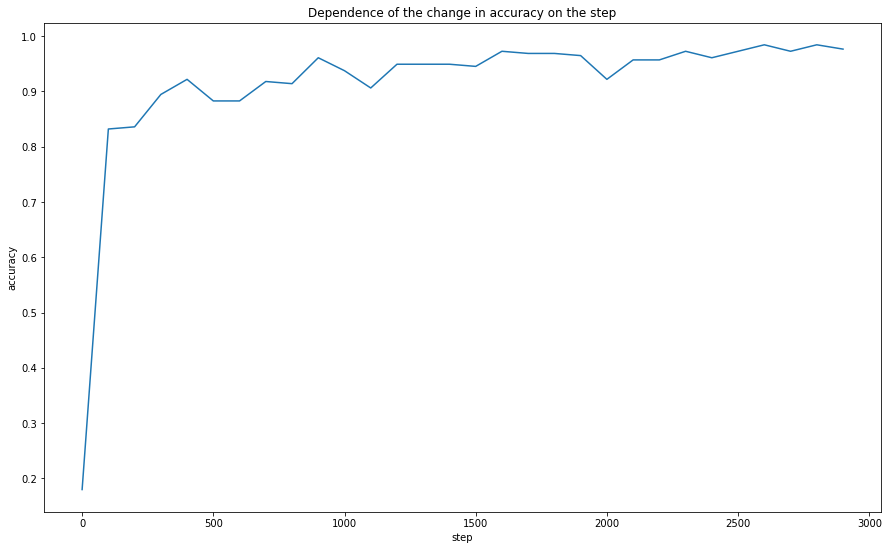

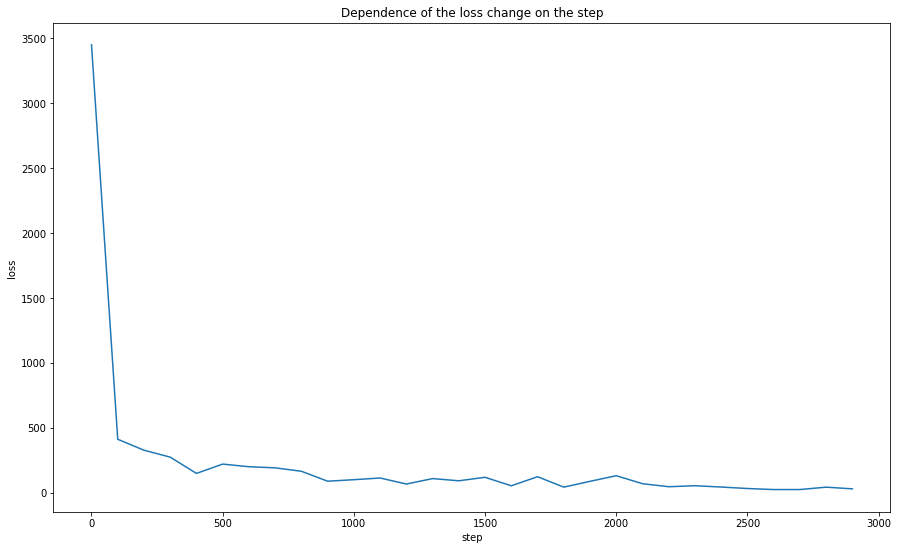

In [11]:
# Виведіть графіки залежності зміни точності та втрат від кроку
# Якщо все зроблено правильно, то точність має зростати, а втрати зменшуватись

steps = np.arange(0, training_steps, display_step)

plt.figure(figsize=(15, 9))
plt.plot(steps, accuracy_history, label='accuracy')
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("Dependence of the change in accuracy on the step")

plt.figure(figsize=(15, 9))
plt.plot(steps, loss_history, label='loss')
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Dependence of the loss change on the step")

plt.show()

In [12]:
# Обчисліть точність навченої нейромережі

y_pred = neural_net(x_test)
acc = accuracy(y_pred, y_test)

print(f"Точність навченої мережі: {acc:.4f}")

Точність навченої мережі: 0.8834


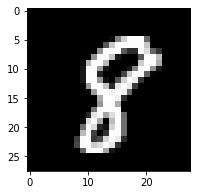

Model prediction: 8


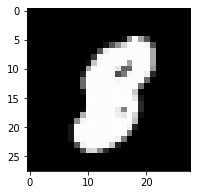

Model prediction: 8


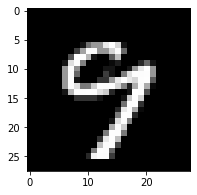

Model prediction: 9


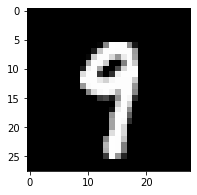

Model prediction: 9


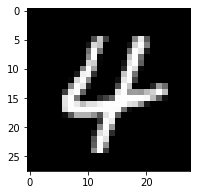

Model prediction: 4


In [17]:
# Протестуємо навчену нейромережу на 10 зображеннях. 
# З тестової вибірки візьміть 5 випадкових зображень та передайте їх у нейронну мережу.
# Виведіть зображення та випишіть поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється ваша нейронна мережа і якщо так, то як часто?

random_indexes = np.random.choice(len(x_test), 5)
predictions = neural_net(x_test[random_indexes])

for i, index in enumerate(random_indexes):
    plt.figure(figsize=(3, 3))
    plt.imshow(x_test[index].reshape((28, 28)), cmap='gray')
    plt.show()
    print(f"Model prediction: {np.argmax(predictions.numpy()[i])}")

На випадкових 5 зображенях помилок не було.